In [1]:
# Change directory to the root so that relative path loads work correctly
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass

/global/u1/g/gelijerg/Projects/pyinsulate


In [2]:
from experiments.A_proof_of_constraint.visualize import plot_loss, plot_constraints, plot_time
import os
import sys
import torch

In [3]:
# Files to load
directory = "/global/u1/g/gelijerg/Projects/pyinsulate/results"
files = [
    'proof-of-constraint_2019-07-22-10-22-21.pth',
]

In [4]:
# Load files
summaries = [torch.load(f"{directory}/{f}") for f in files]
filenames = [os.path.splitext(f)[0] for f in files]

ProofOfConstraintMonitor: {'epoch' 'loss' 'batch_size' 'constraints' 'total' 'load_data' 'forward_pass' 'guard' 'compute_loss' 'compute_constraints' 'compute_reweighted_loss' 'step_optimizer'}
Saving loss plot to /global/u1/g/gelijerg/Projects/pyinsulate/results/training-loss_proof-of-constraint_2019-07-22-10-22-21.png
Saving constraint satisfaction plot to /global/u1/g/gelijerg/Projects/pyinsulate/results/training-constraint_proof-of-constraint_2019-07-22-10-22-21.png
Saving compute time plot to /global/u1/g/gelijerg/Projects/pyinsulate/results/compute-time_proof-of-constraint_2019-07-22-10-22-21.png


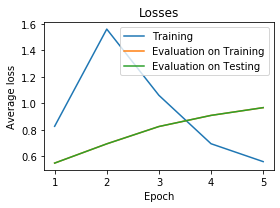

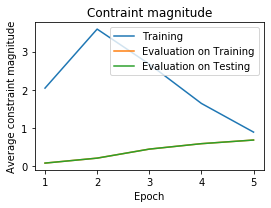

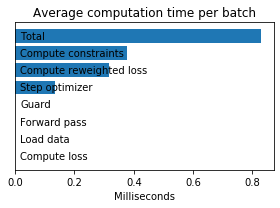

In [5]:
# Do some plotting
for summary, filename in zip(summaries, filenames):
    training_monitor = summary['training_monitor']
    evaluation_train_monitor = summary['evaluation_train_monitor']
    evaluation_test_monitor = summary['evaluation_test_monitor']

    print(training_monitor)
    plot_loss([training_monitor, evaluation_train_monitor, evaluation_test_monitor], [
              "Training", "Evaluation on Training", "Evaluation on Testing"], f"training-loss_{filename}")

    plot_constraints([training_monitor, evaluation_train_monitor, evaluation_test_monitor], [
        "Training", "Evaluation on Training", "Evaluation on Testing"], f"training-constraint_{filename}")

    plot_time(training_monitor, f"compute-time_{filename}")

In [6]:
print('done!')

done!
